<a href="https://colab.research.google.com/github/Ray7788/COMP34212RX/blob/main/jupyter_notebook/COMP34212_Lab1b_Keras_MLP_MNIST_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MLP for Complex Problems: The MNIST dataset
=========


In this exercise we will first learn to use the simple perceptron network (input-output layers only) and a Multi-Layer Perceptron (MLP, with one or more hidden layers). To make the task more interesting than the XOR problem, we will be using a more complex training set. This will be the MNIST dataset, a well known neural network problem for the recognition of the 10 handwritten characters from 0 to 9 ([MNIST](http://yann.lecun.com/exdb/mnist/)).

This exercise is based on the  Gulli & Pal (2017) 'Deep Learning with Keras' textbook, with some additional code to help us understand and test the programme.


**Importing the libraries and defining the main training parameters**

The initial code is necessary to prepare the data and the simulation (hyper)parameters.
We first import numpy. In our case we will use it to create and pre-process the array of the training data sets. We then import a few functions from Keras (we used some of these in our previous XOR exercise). The matplotlib library will be used for visualising some MNIST images and the plot of the training results.

The code also defines the variables for some of the main parameters used throughout this program.
The random seed definition is also important to be able to repeat the same parameter configuration.

In [1]:
# import of numpy and keras libraries
from __future__ import print_function
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers.legacy import SGD
from tensorflow.keras import utils
import matplotlib.pyplot as plt

# variables for network and training
N_EPOCH = 200 # initially set at 200 ; you can change this later
BATCH_SIZE = 128
VERBOSE = 1 # Record training log
N_CLASSES = 10   # number of classes/categories of digits from 0 to 9, i.e. number of output units
OPTIMIZER = SGD(learning_rate=0.1) # Stochastic gradient descent optimiser
N_HIDDEN = 128   # number of hidden units
VALIDATION_SPLIT=0.2 # proportion of the dataset used for validation, with remaining .8 for training

#each 2D image consists of 28x28 values/pixels, which needs to be reshaped in a vector of 784 pixels
RESHAPED = 784 # converge into one vector

# random seed number to be used for reproducibility
np.random.seed(1671)


**Preparing the MNIST dataset and visualising the input images**

This part of the code prepares the input and output training set, and the corresponding test sets.
It also visualises a sample image. The MNIST dataset is included in the Keras program and we do not need to use and external file.

Training data input shape:  (60000, 28, 28)
Training data output shape:  (60000,)
Test data input shape:  (10000, 28, 28)
Test data ouput shape:  (10000,)
Sample input image: [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0  67 232  39   0   0   0   0   0]
 [  0   0   0   0  62  81   0   0   0   0   0   0   0   0   0   0   0   0
    0   0 120 180  39   0   0   0   0   0]
 [  0 

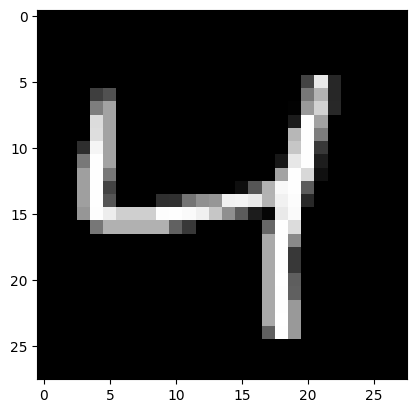

In [2]:

# data: shuffled and split between train and test sets, loading and using the Keras mnist dataset
(input_X_train, output_Y_train), (input_X_test, output_Y_test) = mnist.load_data()

# print the shapes of the input and output data
print("Training data input shape: " , input_X_train.shape)
print("Training data output shape: " , output_Y_train.shape)
print("Test data input shape: " , input_X_test.shape)
print("Test data ouput shape: " , output_Y_test.shape)

# visualisation of the numerical vector and plot of a selected image
Selected_Image = 2
image = input_X_train[Selected_Image]
print ("Sample input image: " + str(image))
plt.imshow(image, cmap='gray')
plt.show()


The input images now have to be reshaped as a linear vector. That is, we go from a 2D image of 28x28 pixels, to a linear vector of 784 (i.e. 28*28) pixels, to be passed as the 784 input units. Moreover, the initial pixel grey values given as type __int__ in the range 0-255 will be normalised to the __float32__ type in the range 0-1.


In [3]:
# use 60000 images for training, 10000 for validation test
input_X_train = input_X_train.reshape(60000, RESHAPED)
input_X_test = input_X_test.reshape(10000, RESHAPED)
input_X_train = input_X_train.astype('float32')  # default
input_X_test = input_X_test.astype('float32')

# normalisation of the pixel values from 0-255 range to 0-1 range
input_X_train /= 255
input_X_test /= 255

print ("Input data ready")

Input data ready


**Preparing the output labels**

This code converts the output data into categorical (one-hot encoding) vectors of 0s and 1s.
See example of the visualisation of the one-hot vector for the selected image.

In [4]:
# convert class vectors to binary class matrices
output_Y_train = utils.to_categorical(output_Y_train, N_CLASSES)
output_Y_test = utils.to_categorical(output_Y_test, N_CLASSES)

# print the categorical, one-hot output vector for the sample image
label = output_Y_train[Selected_Image] # represent4
print ("One-hot-vector: " + str(label))

One-hot-vector: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


Training the Simple Perceptron
=========

**Defining the network: Simple Perceptron**

We will start by training a simple perceptron, i.e. a network with an input layer (the 784 input values/pixels) connected to the output layer (the 10 number classes)

In [5]:
# Defaults sequential model
model = Sequential()

# Dense layer for all to all connections
# Define the output layer with 10 output units, and softmax activation as categorical output
model.add(Dense(N_CLASSES, input_shape=(RESHAPED,)))    # 784
model.add(Activation('softmax'))

# Use categorical crossentropy for the loss evaluation, and the accuracy metrics
# we previously chose the SGD optimiser in the OPTIMIZER variable definition
model.compile(loss='categorical_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy'])

#show the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                7850      
                                                                 
 activation (Activation)     (None, 10)                0         
                                                                 
Total params: 7850 (30.66 KB)
Trainable params: 7850 (30.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**Let's train the simple perceptron network**

Let's now train (fit) the network with the above-defined batch size (128), and number of epochs (200). We save the training results into the history variable.

Here we use the previous __VALIDATION_SPLIT=0.2__ definition to split the dataset into a 20% (0.2) validation set and the remaning 80% as training set.

In [6]:
#train the network
history = model.fit(input_X_train, output_Y_train, batch_size=BATCH_SIZE, epochs=N_EPOCH, verbose=VERBOSE, validation_split=VALIDATION_SPLIT)


Epoch 1/200
375/375 [==============================] - 5s 10ms/step - loss: 0.6282 - accuracy: 0.8438 - val_loss: 0.3984 - val_accuracy: 0.8945
Epoch 2/200
375/375 [==============================] - 4s 12ms/step - loss: 0.3960 - accuracy: 0.8920 - val_loss: 0.3489 - val_accuracy: 0.9062
Epoch 3/200
375/375 [==============================] - 3s 8ms/step - loss: 0.3595 - accuracy: 0.8995 - val_loss: 0.3302 - val_accuracy: 0.9072
Epoch 4/200
375/375 [==============================] - 1s 4ms/step - loss: 0.3408 - accuracy: 0.9039 - val_loss: 0.3157 - val_accuracy: 0.9132
Epoch 5/200
375/375 [==============================] - 1s 4ms/step - loss: 0.3286 - accuracy: 0.9079 - val_loss: 0.3087 - val_accuracy: 0.9140
Epoch 6/200
375/375 [==============================] - 1s 3ms/step - loss: 0.3199 - accuracy: 0.9106 - val_loss: 0.3021 - val_accuracy: 0.9161
Epoch 7/200
375/375 [==============================] - 1s 3ms/step - loss: 0.3131 - accuracy: 0.9122 - val_loss: 0.2986 - val_accuracy: 0.91

**Looking at the results of the trained network**

Let's evaluate the model to see how well it has learned ( or not) the MNIST problem.

In [7]:
#test the network using the generalisation test dataset
score = model.evaluate(input_X_test, output_Y_test, verbose=VERBOSE)
print("\nTest score/loss:", score[0])
print("Test accuracy:", score[1])


313/313 [==============================] - 1s 2ms/step - loss: 0.2702 - accuracy: 0.9255

Test score/loss: 0.2702391445636749
Test accuracy: 0.9254999756813049


Training the Multi-Layer Perceptron
=========
**Defining the network: Multi-Layer Perceptron**

We will now create a multi-layer perceptron with 784 input units, two hidden layers with 128 hidden units each, and an output layer with the 10 units.



In [8]:
N_EPOCH = 20 # we need fewer epoch than before, as the multi-layer percetpron can learn faster.
N_HIDDEN = 128

model = Sequential()

# Hidden layer 1 with 128 hidden units and ReLu activation function
model.add(Dense(N_HIDDEN, input_shape=(RESHAPED,)))
model.add(Activation('relu'))
# Hidden layer 2 with 128 hidden units and ReLu activation function
model.add(Dense(N_HIDDEN))
model.add(Activation('relu'))

# output layer with 10 units and softmax activation
model.add(Dense(N_CLASSES))
model.add(Activation('softmax'))

# Summary of the whole model
model.summary()

# model compilation
model.compile(loss='categorical_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 128)               100480    
                                                                 
 activation_1 (Activation)   (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 activation_2 (Activation)   (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
 activation_3 (Activation)   (None, 10)                0         
                                                                 
Total params: 118282 (462.04 KB)
Trainable params: 118

**Let's train the mulri-layer perceptron network**

Let's now train (fit) the network with the above-defined batch size (128), and number of epochs (20).

In [9]:
#train the network
history = model.fit(input_X_train, output_Y_train, batch_size=BATCH_SIZE, epochs=N_EPOCH, verbose=VERBOSE, validation_split=VALIDATION_SPLIT)


Epoch 1/20
375/375 [==============================] - 3s 8ms/step - loss: 0.5028 - accuracy: 0.8613 - val_loss: 0.2643 - val_accuracy: 0.9249
Epoch 2/20
375/375 [==============================] - 3s 7ms/step - loss: 0.2382 - accuracy: 0.9305 - val_loss: 0.2056 - val_accuracy: 0.9411
Epoch 3/20
375/375 [==============================] - 2s 6ms/step - loss: 0.1829 - accuracy: 0.9466 - val_loss: 0.1733 - val_accuracy: 0.9510
Epoch 4/20
375/375 [==============================] - 2s 6ms/step - loss: 0.1489 - accuracy: 0.9560 - val_loss: 0.1428 - val_accuracy: 0.9596
Epoch 5/20
375/375 [==============================] - 2s 6ms/step - loss: 0.1244 - accuracy: 0.9634 - val_loss: 0.1300 - val_accuracy: 0.9644
Epoch 6/20
375/375 [==============================] - 2s 6ms/step - loss: 0.1071 - accuracy: 0.9688 - val_loss: 0.1188 - val_accuracy: 0.9642
Epoch 7/20
375/375 [==============================] - 3s 9ms/step - loss: 0.0924 - accuracy: 0.9727 - val_loss: 0.1126 - val_accuracy: 0.9665
Epoch 

**Looking at the results of the trained network**

Let's explotre the results both for the score and accuracy values, as well as to visualise the plots of these values during the training.

In [10]:
#test the network
score = model.evaluate(input_X_test, output_Y_test, verbose=VERBOSE)
print("\nTest score/loss:", score[0])
print("Test accuracy:", score[1])

313/313 [==============================] - 1s 2ms/step - loss: 0.0787 - accuracy: 0.9769

Test score/loss: 0.0786760225892067
Test accuracy: 0.9768999814987183


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


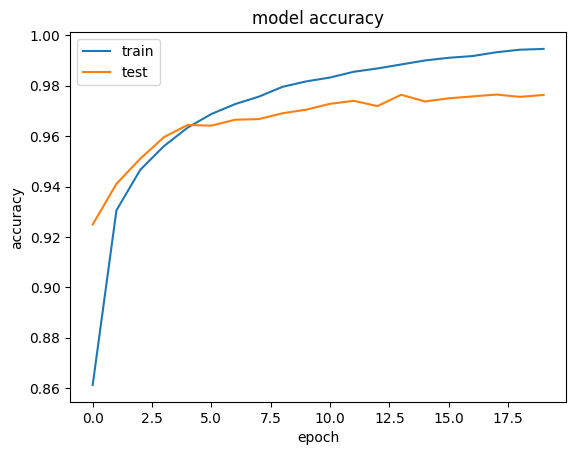

In [11]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


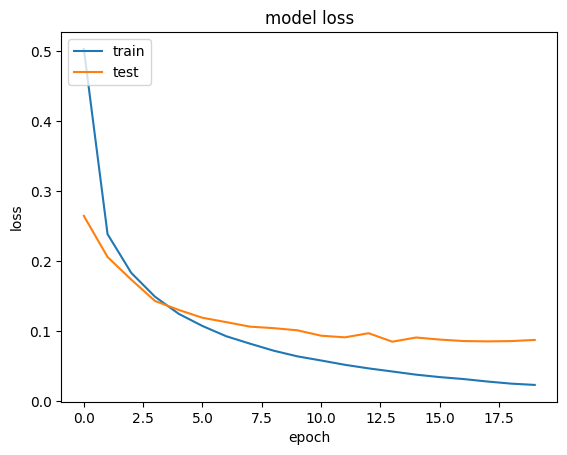

In [12]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Adding weight droputs**

An efficient way to reduce the number of parameters (weights) to be trained, as well as to increase generalisation capabilities, is to randomly remove (i.e. __dropout__) a certain proportion of the nodes at random in each epoch.

In [13]:
# import the dropout layer type
from tensorflow.keras.layers import Dropout

# Probability of weights dropout
P_DROPOUT = 0.3

# We can increse this parameter afterwards
N_EPOCH = 20

model = Sequential()
model.add(Dense(N_HIDDEN, input_shape=(RESHAPED,)))
model.add(Activation('relu'))
model.add(Dropout(P_DROPOUT))
model.add(Dense(N_HIDDEN))
model.add(Activation('relu'))
model.add(Dropout(P_DROPOUT))
model.add(Dense(N_CLASSES))
model.add(Activation('softmax'))

# model compilation
model.summary()

# model compilation
model.compile(loss='categorical_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy'])


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               100480    
                                                                 
 activation_4 (Activation)   (None, 128)               0         
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                                 
 activation_5 (Activation)   (None, 128)               0         
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 10)               

**Let's train the multi-layer perceptron network with DROPOUT**

Let's now train (fit) the above dropout network with the above-defined batch size (128), and number of epochs (250).

In [14]:
#train the network
history = model.fit(input_X_train, output_Y_train, batch_size=BATCH_SIZE, epochs=N_EPOCH, verbose=VERBOSE, validation_split=VALIDATION_SPLIT)


Epoch 1/20
375/375 [==============================] - 3s 7ms/step - loss: 0.6910 - accuracy: 0.7866 - val_loss: 0.2711 - val_accuracy: 0.9212
Epoch 2/20
375/375 [==============================] - 4s 9ms/step - loss: 0.3410 - accuracy: 0.8990 - val_loss: 0.1991 - val_accuracy: 0.9438
Epoch 3/20
375/375 [==============================] - 2s 6ms/step - loss: 0.2722 - accuracy: 0.9199 - val_loss: 0.1659 - val_accuracy: 0.9522
Epoch 4/20
375/375 [==============================] - 2s 6ms/step - loss: 0.2312 - accuracy: 0.9328 - val_loss: 0.1456 - val_accuracy: 0.9569
Epoch 5/20
375/375 [==============================] - 2s 6ms/step - loss: 0.2036 - accuracy: 0.9395 - val_loss: 0.1301 - val_accuracy: 0.9610
Epoch 6/20
375/375 [==============================] - 3s 7ms/step - loss: 0.1828 - accuracy: 0.9454 - val_loss: 0.1230 - val_accuracy: 0.9628
Epoch 7/20
375/375 [==============================] - 3s 9ms/step - loss: 0.1686 - accuracy: 0.9504 - val_loss: 0.1157 - val_accuracy: 0.9657
Epoch 

**Looking at the results of the trained dropout network**

Let's explore the effects of adding the weight dropout on the network performance.

You can see that the dropout has further improved our results.

313/313 [==============================] - 1s 2ms/step - loss: 0.0781 - accuracy: 0.9752

Test score: 0.07812277227640152
Test accuracy: 0.9751999974250793
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


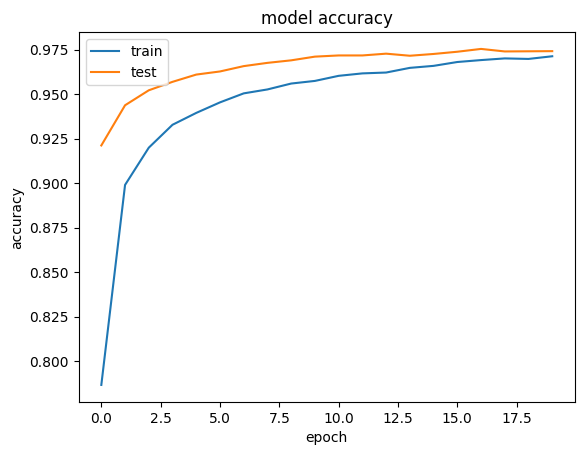

In [15]:
#test the network
score = model.evaluate(input_X_test, output_Y_test, verbose=VERBOSE)
print("\nTest score:", score[0])
print("Test accuracy:", score[1])

# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Exploring Training Hyperparameters
-------------

You can explore the role of various hyperparameters to see how you can further improve the MLP model's performance on the MNIST dataset.

For example, if you increase the number of epochs for the dropout network to 250, you will see that the test and train accuracy errors will converge (accuracy closer to 97% for both training and test), which means that we have achieved the best tradeoff between training and testing.

You can carry out many additional simulations on hypeparameter exploration where you can try for example:

- different number of epochs
- different learning rate
- different number of hidden nodes
- different proportion of dropout rates
- different optimisers in addition to SGD (e.g. RMSprop, Adam)
- different batch size

This final exercise will constitute the first neural network coursework. See Coursework specification documenty for more details.


Conclusions
-------------

With this tutorial we have practiced the training of both a Simple Perceptron, and a Multi-Layer Perceptron, with a benchmark dataset containing images of handwritten numbers.
This helped us understand how to load the datase, visualise it, and visualise the training history and the effects of adding hidden layers and then adding weight dropout.

**Copyright (c)** 2022 Angelo Cangelosi, MIT License. Code and examples adapted from Gulli & Pal (2017) Deep Learning with Keras. Punkt Publishing. With further contribution from Wenjie Huang.